In [ ]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
# adata=sc.read_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination.h5ad'),backed='r')
# adata=adata[~adata.obs['dataset'].isin(['jorstad_cross_areal','krienen_marmoset']),:]
# adata.write_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'))

In [ ]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall.h5ad'),backed='r')
#adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part0.h5ad'),backed='r')

adata.obsm["X_original_umap"]=adata.obsm["X_umap"]
sc.pl.umap(adata,color='species')

In [ ]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/')
import antipode_model
from antipode_model import *
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import model_modules
from model_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *

import importlib
antipode_model=importlib.reload(antipode_model)
from antipode_model import *

import importlib
model_modules=importlib.reload(model_modules)
from model_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *

import importlib
train_utils=importlib.reload(train_utils)
from train_utils import *

import importlib
plotting=importlib.reload(plotting)
from plotting import *



In [ ]:
class AntipodeTrainingMixin:
    '''
    Mixin class providing functions to actually run ANTIPODE
    can use supervised taxonomy by training only phase2
    '''
    
    def save_params_to_uns(self,prefix=''):
        pstore=param_store_to_numpy()
        pstore={n:pstore[n] for n in pstore.keys() if not re.search('encoder|classifier|\$\$\$',n)}
        self.adata_manager.adata.uns[prefix+'param_store']=pstore

    def get_antipode_outputs(self,batch_size=2048,device='cuda'):
        if 'species_onehot' not in self.adata_manager.adata.obsm.keys():
            self.adata_manager.adata.obsm['species_onehot']=numpy_onehot(self.adata_manager.adata.obs['species'].cat.codes)
        self.adata_manager.register_new_fields([scvi.data.fields.ObsmField('species_onehot','species_onehot')])
    
        field_types={"s":np.float32,"species_onehot":np.float32}
        dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=32,drop_last=False,shuffle=False,data_and_attributes=field_types)#supervised_field_types for supervised step 
        encoder_outs=batch_output_from_dataloader(dataloader,self.zl_encoder,batch_size=batch_size,device=device)
        encoder_outs[0]=self.z_transform(encoder_outs[0])
        encoder_out=[x.detach().cpu().numpy() for x in encoder_outs]
        classifier_outs=batch_torch_outputs([(self.z_transform(encoder_outs[0]))],self.classifier,batch_size=batch_size,device='cuda')
        classifier_out=[x.detach().cpu().numpy() for x in classifier_outs]
        bernoulli_outs=batch_torch_outputs([(self.z_transform(encoder_outs[0]))],self.bernoulator,batch_size=batch_size,device='cuda')
        bernoulli_out=[x.detach().cpu().numpy() for x in bernoulli_outs]
        return encoder_out,classifier_out,bernoulli_out
    
    def store_outputs(self,device='cuda',prefix=''):
        self.save_params_to_uns(prefix='')
        self.to('cpu')
        self.eval()
        antipode_outs=self.get_antipode_outputs(batch_size=2048,device=device)
        particle=antipode_outs[1][0]
        self.adata_manager.adata.obsm[prefix+'X_antipode']=antipode_outs[0][0]
        self.adata_manager.adata.obsm[prefix+'bernoullis']=antipode_outs[2][0]
        self.adata_manager.adata.obs[prefix+'psi']=antipode_outs[1][1]
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = antipode_outs[1][0].argmax(1)
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = self.adata_manager.adata.obs[prefix+'antipode_cluster'].astype(str)

    def fix_scale_factor(self,svi,x,ideal_val=0.1):
        o1=svi.evaluate_loss(*x)
        s1=self.scale_factor
        s2=ideal_val*s1/o1
        self.scale_factor=s2
    
    def common_training_loop(self, dataloader, max_steps, scheduler, svi, print_every, device, steps=0):
        self.losses = []
        pbar = tqdm.tqdm(total=max_steps, position=0)
        while steps < max_steps:
            for x in dataloader:
                x['step'] = torch.ones(1).to(device) * steps
                x = [x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                if self.scale_factor == 1.:
                    self.fix_scale_factor(svi, x)
                pbar.update(1)
                loss = svi.step(*x)
                steps += 1
                if hasattr(scheduler, 'step'):
                    scheduler.step()
                if steps >= max_steps - 1 :
                    break
                
                self.losses.append(loss)
                if steps % print_every == 0:
                    pbar.write(f"[Step {steps:02d}]  Loss: {np.mean(self.losses[-print_every:]):.5f}")
        pbar.close()
        try:
            self.allDone()
        except:
            pass


    def setup_scheduler(self, max_learning_rate, max_steps, one_cycle_lr):
        if one_cycle_lr:
            return pyro.optim.OneCycleLR({
                'max_lr': max_learning_rate,
                'total_steps': max_steps,
                'div_factor': 100,
                'optim_args': {},
                'optimizer': torch.optim.Adam
            })
        else:
            return pyro.optim.ClippedAdam({
                'lr': max_learning_rate,
                'lrd': (1 - (5e-6))
            })

    def train_phase(self, phase, max_steps, print_every=10000, device='cuda', max_learning_rate=0.001, num_particles=1, one_cycle_lr=True, steps=0, batch_size=32,freeze_encoder=None):
        self.scale_factor=1.
        freeze_encoder = True if freeze_encoder is None and phase == 2 else freeze_encoder
        freeze_encoder = False if freeze_encoder is None else  freeze_encoder
        self.set_freeze_encoder(freeze_encoder) 
        supervised_field_types=self.field_types.copy()
        supervised_fields=self.fields.copy()
        supervised_field_types["taxon"]=np.float32
        field_types=self.field_types if phase != 2 else supervised_field_types
        dataloader = scvi.dataloaders.AnnDataLoader(self.adata_manager, batch_size=batch_size, drop_last=True, shuffle=True, data_and_attributes=field_types)
        scheduler = self.setup_scheduler(max_learning_rate, max_steps, one_cycle_lr)
        if phase == 1:
            elbo_class = pyro.infer.JitTrace_ELBO
        else:
            elbo_class = pyro.infer.JitTraceEnum_ELBO
        elbo = elbo_class(num_particles=num_particles, strict_enumeration_warning=False)
        hide_params=[name for name in pyro.get_param_store() if re.search('encoder',name)]
        guide=self.guide if not self.freeze_encoder else poutine.block(self.guide,hide=hide_params)
        svi = SVI(self.model, guide, scheduler, elbo)  
        self.train()
        self.zl_encoder.eval() if self.freeze_encoder else self.zl_encoder.train()
        self = self.to(device)
        self.set_approx(phase == 1)
        return self.common_training_loop(dataloader, max_steps, scheduler, svi, print_every, device, steps)

    def allDone(self):
        print("Finished training!")
        from IPython.display import Audio, display
        display(Audio(url='https://notification-sounds.com/soundsfiles/Meditation-bell-sound.mp3', autoplay=True))

    def prepare_phase_2(self,cluster='kmeans'):
        '''Run this if not running in supervised only mode (JUST phase2 with provided obsm clustering), 
        runs kmeans if cluster=kmeans, else uses the obs column provided by cluster'''
        if cluster=='kmeans':
            kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=self.num_labels,init='k-means++',max_iter=1000,reassignment_ratio=0.001,n_init=100,random_state=0).fit(self.adata_manager.adata.obsm['X_antipode'])
            self.adata_manager.adata.obs['kmeans']=kmeans.labels_
            self.adata_manager.adata.obs['kmeans']=self.adata_manager.adata.obs['kmeans'].astype(int).astype('category')
            self.adata_manager.adata.obsm['kmeans_onehot']=numpy_onehot(self.adata_manager.adata.obs['kmeans'].cat.codes,num_classes=self.num_labels)
        else:
            self.adata_manager.adata.obs[cluster]=self.adata_manager.adata.obs[cluster].astype('category')
            self.adata_manager.adata.obsm[cluster+'_onehot']=numpy_onehot(self.adata_manager.adata.obs[cluster].cat.codes,num_classes=self.num_labels)

        self.adata_manager.register_new_fields([make_field('taxon',('obsm',cluster+'_onehot'))])
        new_logits=torch.tensor(group_aggr_anndata(self.adata_manager.adata,[cluster], agg_func=np.mean,layer='bernoullis',obsm=True)[0]).float()
        pyro.get_param_store().__setitem__('taxon_mu',new_logits.to(pyro.param('locs').device))
        new_std=torch.tensor(group_aggr_anndata(self.adata_manager.adata,[cluster], agg_func=np.std,layer='bernoullis',obsm=True)[0]).float()
        pyro.get_param_store().__setitem__('taxon_sigma',new_std.to(pyro.param('locs').device))   
        self.adata_manager.adata.obs[cluster]=self.adata_manager.adata.obs[cluster].astype(str).astype('category')
        pyro.get_param_store().__delitem__('discov_dm')
        pyro.get_param_store().__delitem__('batch_dm')
        pyro.get_param_store().__delitem__('discov_di')
        pyro.get_param_store().__delitem__('batch_di')
        pyro.get_param_store().__delitem__('cluster_intercept')
        self.dm=MAPLaplaceModule(self,'discov_dm',[self.num_discov,self.num_labels,self.num_latent],[self.discov_plate,self.label_plate,self.latent_plate])
        self.bm=MAPLaplaceModule(self,'batch_dm',[self.num_batch,self.num_labels,self.num_latent],[self.batch_plate,self.label_plate,self.latent_plate])
        self.di=MAPLaplaceModule(self,'discov_di',[self.num_discov,self.num_labels,self.num_var],[self.discov_plate,self.label_plate,self.var_plate])
        self.bei=MAPLaplaceModule(self,'batch_di',[self.num_batch_embed,self.num_labels,self.num_var],[self.batch_embed_plate,self.label_plate,self.var_plate])
        self.ci=MAPLaplaceModule(self,'cluster_intercept',[self.num_labels, self.num_var],[self.label_plate,self.var_plate],param_only=self.intercept_as_param)


class ANTIPODE(PyroBaseModuleClass,AntipodeTrainingMixin):#
    '''
    ANTIPODE (Single Cell Ancestral Node particleomy Inference by Parcellation of Differential Expression) 
    is a variational inference model developed for the simultaneous analysis (DE) and 
    categorization (particleomy generation) of cell types across evolution (or now any covariate) using single-cell RNA-seq data.
    

    Parameters:
    adata (AnnData): An AnnData object containing the single-cell dataset.
    discov_pair (tuple): A tuple indicating the key and location of the discovery covariate 
                         in the AnnData object. Format: ('key', 'location'), where location is 
                         either 'obs' or 'obsm'.
    batch_pair (tuple): A tuple indicating the key and location of the batch covariate 
                        in the AnnData object. Format: ('key', 'location'), where location is 
                        either 'obs' or 'obsm'.
    num_var (int): Number of variables (features) in the dataset.
    num_latent (int, optional): Number of latent dimensions. Defaults to 50.
    scale_factor (float, optional): Scaling factor for data normalization. If None, it is inferred from the data.
    prior_scale (float, optional): Scale of the Laplace prior distributions. Defaults to 100.
    dcd_prior (float, optional): Scale of the prior for the decoder. If None, defaults to a specific inferred value.
    theta_prior (float, optional): Init value for the inverse dispersion of the negative binomial.
    num_batch_embed (int, optional): Number of batch embeddings. Defaults to 10.
    classifier_hidden (list of int, optional): Sizes of hidden layers for the classifier network. Defaults to [3000, 3000, 3000].
    encoder_hidden (list of int, optional): Sizes of hidden layers for the encoder network. Defaults to [6000, 5000, 3000, 1000].
    '''
    def __init__(self, adata, discov_pair, batch_pair, layer, 
                 num_latent=50, num_labels=50,num_particles=50, scale_factor=None, prior_scale=100,dcd_prior=None,use_psi=True,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,
                 num_batch_embed=10,theta_prior=50.,scale_init_val=0.01,
                 classifier_hidden=[3000,3000,3000],encoder_hidden=[6000,5000,3000,1000],z_transform=None):

        pyro.clear_param_store()

        # Determine num_discov and num_batch from the AnnData object
        self.discov_loc, self.discov_key = discov_pair
        self.batch_loc, self.batch_key = batch_pair
        self.num_discov = adata.obsm[self.discov_key].shape[-1] if self.discov_loc == 'obsm' else len(adata.obs[self.discov_key].unique())
        self.num_batch = adata.obsm[self.batch_key].shape[-1] if self.batch_loc == 'obsm' else len(adata.obs[self.batch_key].unique())
        self.design_matrix = (self.discov_loc == 'obsm')
        self.layer=layer

        self._setup_adata_manager_store: dict[str, type[scvi.data.AnnDataManager]] = {}
        self.num_var = adata.layers[layer].shape[-1]
        self.num_latent = num_latent
        self.scale_factor = 1.0#scale_factor if scale_factor is not None else 2e2 / (self.num_var * num_particles * num_latent)
        self.num_particles= num_particles
        self.num_batch_embed = num_batch_embed
        self.temperature = 0.1
        self.epsilon = 0.006
        self.approx = False
        self.prior_scale = prior_scale
        self.use_psi=use_psi
        self.loc_as_param=loc_as_param
        self.zdw_as_param=zdw_as_param
        self.intercept_as_param=intercept_as_param
        self.theta_prior=theta_prior
        self.scale_init_val=scale_init_val
        self.leaf_scale_only=False
        self.num_labels=num_labels
        
        self.dcd_prior=torch.zeros((self.num_discov,self.num_var)) if dcd_prior is None else dcd_prior#Use this for 
        
        # Initialize plates to be used during sampling
        self.var_plate=pyro.plate('var_plate',self.num_var,dim=-1)
        self.discov_plate=pyro.plate('discov_plate',self.num_discov,dim=-3)
        self.batch_plate=pyro.plate('batch_plate',self.num_batch,dim=-3)
        self.latent_plate=pyro.plate('latent_plate',self.num_latent,dim=-1)
        self.latent_plate2=pyro.plate('latent_plate2',self.num_latent,dim=-2)
        self.particle_plate=pyro.plate('particle_plate',self.num_particles,dim=-2)
        self.particle_plate2=pyro.plate('particle_plate2',self.num_particles,dim=-1)
        self.label_plate=pyro.plate('label_plate',self.num_labels,dim=-2)
        self.batch_embed_plate=pyro.plate('batch_embed_plate',self.num_batch_embed,dim=-3)

        #Initialize MAP inference modules
        self.dm=MAPLaplaceModule(self,'discov_dm',[self.num_discov,self.num_particles,self.num_latent],[self.discov_plate,self.particle_plate,self.latent_plate])
        self.bm=MAPLaplaceModule(self,'batch_dm',[self.num_batch,self.num_particles,self.num_latent],[self.batch_plate,self.particle_plate,self.latent_plate])
        self.di=MAPLaplaceModule(self,'discov_di',[self.num_discov,self.num_particles,self.num_var],[self.discov_plate,self.particle_plate,self.var_plate])
        self.bei=MAPLaplaceModule(self,'batch_di',[self.num_batch_embed,self.num_particles,self.num_var],[self.batch_embed_plate,self.particle_plate,self.var_plate])
        self.ci=MAPLaplaceModule(self,'cluster_intercept',[self.num_particles, self.num_var],[self.particle_plate,self.var_plate],param_only=self.intercept_as_param)
        
        self.dc=MAPLaplaceModule(self,'discov_dc',[self.num_discov,self.num_latent,self.num_var],[self.discov_plate,self.latent_plate2,self.var_plate])
        self.zdw=MAPLaplaceModule(self,'z_decoder_weight',[self.num_latent,self.num_var],[self.latent_plate2,self.var_plate],init_val=((2/self.num_latent)*(torch.rand(self.num_latent,self.num_var)-0.5)),param_only=self.zdw_as_param)
        self.zl=MAPLaplaceModule(self,'locs',[self.num_particles,self.num_latent],[self.particle_plate,self.latent_plate],param_only=self.loc_as_param)
        self.zs=MAPLaplaceModule(self,'scales',[self.num_particles,self.num_latent],[self.particle_plate,self.latent_plate],init_val=self.scale_init_val*torch.ones(self.num_particles,self.num_latent),constraint=constraints.positive,param_only=False)
        self.zld=MAPLaplaceModule(self,'locs_dynam',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=False)
        self.taxon_mu=MAPLaplaceModule(self,'taxon_mu',[self.num_labels,self.num_particles],[],param_only=True)
        self.taxon_sigma=MAPLaplaceModule(self,'taxon_sigma',[self.num_labels,self.num_particles],[self.label_plate,self.particle_plate2],init_val=0.5*torch.ones(self.num_labels,self.num_particles),constraint=constraints.positive,param_only=False)
        
        self.z_transform=null_function if z_transform is None else z_transform#centered_sigmoid#torch.special.expit

        if self.design_matrix:
            fields={'s':('layers',self.layer),
            'discov_ind':('obsm',self.discov_key),
            'batch_ind':('obsm',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.float32,"discov_ind":np.float32}
        else:
            fields={'s':('layers',self.layer),
            'discov_ind':('obs',self.discov_key),
            'batch_ind':('obs',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.int64,"discov_ind":np.int64}

        self.fields=fields
        self.field_types=field_types
        self.setup_anndata(adata, {'discov_ind': discov_pair, 'batch_ind': batch_pair}, self.field_types)
        
        super().__init__()
        # Setup the various neural networks used in the model and guide
        self.z_decoder=ZDecoder(num_latent=self.num_latent, num_var=self.num_var, hidden_dims=[])        
        self.zl_encoder=ZLEncoder(num_var=self.num_var,hidden_dims=encoder_hidden,num_cat_input=self.num_discov,
                    outputs=[(self.num_latent,None),(self.num_latent,softplus)])

        self.bernoulator=Classifier(num_latent=self.num_latent,hidden_dims=[2000,2000,2000],
                    outputs=[(self.num_particles,None),(self.num_particles,softplus)])
        
        self.classifier=Classifier(num_latent=self.num_latent,hidden_dims=classifier_hidden,
                    outputs=[(self.num_labels,None),(1,None),(1,softplus)])

        #Too large to exactly model gene-level batch effects for all cluster x batch
        self.be_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[1000,500,500],
                    out_dim=self.num_batch_embed)
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=False
        self.freeze_encoder=False
        self.prior_scale=prior_scale
        self.args=inspect.getfullargspec(self.model).args[1:]#skip self

    def setup_anndata(self,adata: anndata.AnnData,fields,field_types,**kwargs,):
        
        anndata_fields=[make_field(x,self.fields[x]) for x in self.fields.keys()]
        
        adata_manager = scvi.data.AnnDataManager(
            fields=anndata_fields
        )
        adata_manager.register_fields(adata, **kwargs)
        self.register_manager(adata_manager)
        if fields['discov_ind'][0]=='obsm':
            self.design_matrix=True
            if fields['batch_ind'][0]!='obsm':
                raise Exception("If discov is design matrix, batch must be as well!")

    def register_manager(self, adata_manager: scvi.data.AnnDataManager):
        adata_id = adata_manager.adata_uuid
        self._setup_adata_manager_store[adata_id] = adata_manager
        self.adata_manager=adata_manager
    
    def set_approx(self,b: bool):
        self.approx=b
        
    def set_freeze_encoder(self,b: bool):
        self.freeze_encoder=b
    
    def set_leaf_scale_only(self,b: bool):
        self.leaf_scale_only=b
        
    def model(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("antipode", self)

        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0],dim=-1)
        minibatch_plate2=pyro.plate("minibatch_plate2", s.shape[0],dim=-2)
        l = s.sum(1).unsqueeze(-1)
        
        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        with poutine.scale(scale=self.scale_factor):
            # This gene-level parameter modulates the variance of the observation distribution
            s_theta = pyro.param("s_inverse_dispersion", self.theta_prior * s.new_ones(self.num_var),
                               constraint=constraints.positive)
            
            dcd=pyro.param("discov_constitutive_de", self.dcd_prior.to(s.device))
            if not self.approx:
                particle_mu_param=self.taxon_mu.model_sample(s)
                particle_sigma_param=self.taxon_sigma.model_sample(s)
            
            with minibatch_plate:
                beta_prior_a=1.*s.new_ones(self.num_particles)
                beta_prior_a[0]=10.
                if self.approx:#Bernoulli particles approx?
                    particle_probs = pyro.sample("particle_probs", dist.Beta(beta_prior_a,s.new_ones(self.num_particles),validate_args=True).to_event(1))
                    particle = pyro.sample('particle',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=particle_probs).to_event(1))
                    taxon=taxon_probs=s.new_ones(s.shape[0],self.num_labels)
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Dirichlet(s.new_ones(s.shape[0],self.num_labels),validate_args=True))
                    if sum(taxon.shape) > 1:
                        taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),obs=taxon,infer={'enumerate':'parallel'})
                    else:
                        taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=s.new_ones(s.shape[0],self.num_labels),validate_args=True),infer={'enumerate':'parallel'})
                    particle_mu=oh_index(particle_mu_param,taxon)
                    particle_sigma=oh_index(particle_sigma_param,taxon)
                    particle_probs = safe_sigmoid(pyro.sample("particle_probs", dist.Normal(particle_mu,particle_sigma+self.epsilon,validate_args=True).to_event(1)))
                    particle = pyro.sample('particle',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=particle_probs).to_event(1))

            locs_dynam=self.zld.model_sample(s,scale=fest([taxon_probs],-1))
            discrete_indexer=particle if self.approx else taxon
            continuous_indexer=particle if self.approx else taxon_probs
            locs=self.zl.model_sample(s,scale=fest([particle],-1))
            scales=self.zs.model_sample(s,scale=fest([particle],-1))
            discov_dm=self.dm.model_sample(s,scale=fest([discov,continuous_indexer],-1))
            discov_di=self.di.model_sample(s,scale=fest([discov,continuous_indexer],-1))
            batch_dm=self.bm.model_sample(s,scale=fest([batch,continuous_indexer],-1))
            batch_embed=centered_sigmoid(self.be_nn(batch))
            bei=self.bei.model_sample(s,scale=fest([batch_embed,continuous_indexer],-1))
            cluster_intercept=self.ci.model_sample(s,scale=fest([continuous_indexer],-1))
            
            with minibatch_plate:
                bi=torch.einsum('...bi,...ijk->...bjk',batch_embed,bei)
                bi=torch.einsum('...bj,...bjk->...bk',discrete_indexer,bi)
                psi = centered_sigmoid(pyro.sample('psi',dist.Laplace(s.new_zeros(s.shape[0],1),self.prior_scale*s.new_ones(s.shape[0],1)).to_event(1)))
                psi = 0 if self.approx else psi
                this_locs=oh_index(locs,particle)
                this_scales=oh_index(scales,particle)
                z=pyro.sample('z', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))
                pyro.sample('z_cost', dist.Laplace(this_locs,self.prior_scale*s.new_ones(this_locs.shape),validate_args=True).to_event(1))

            cur_discov_dm = oh_index1(discov_dm, discov_ind) if self.design_matrix else discov_dm[discov_ind]
            cur_batch_dm = oh_index1(batch_dm, batch_ind) if self.design_matrix else batch_dm[batch_ind]
            cur_dcd = oh_index(dcd, discov) if self.design_matrix else  dcd[discov_ind]

            if self.design_matrix:
                z=z+oh_index2(oh_index1(discov_dm,discov_ind),discrete_indexer) + oh_index2(oh_index1(batch_dm,batch_ind),discrete_indexer)+(oh_index(locs_dynam,taxon)*psi)
            else:
                z=z+oh_index2(discov_dm[discov_ind],discrete_indexer) + oh_index2(batch_dm[batch_ind],discrete_indexer)+(oh_index(locs_dynam,taxon)*psi)
            fake_z=oh_index(locs,particle)+oh_index2(discov_dm[discov_ind],continuous_indexer) + oh_index2(batch_dm[batch_ind],continuous_indexer)+(oh_index(locs_dynam,taxon_probs)*psi)
            z=self.z_transform(z)
            fake_z=self.z_transform(fake_z)
            z_decoder_weight=self.zdw.model_sample(s,scale=fest([fake_z.abs()],-1))
            discov_dc=self.dc.model_sample(s,scale=fest([discov,fake_z.abs()],-1))
            cur_discov_di = oh_index1(discov_di, discov_ind) if self.design_matrix else discov_di[discov_ind]
            cur_discov_dc = oh_index1(discov_dc, discov_ind) if self.design_matrix else discov_dc[discov_ind]
            cur_discov_di=oh_index2(cur_discov_di,discrete_indexer)
            cur_cluster_intercept=oh_index(cluster_intercept,discrete_indexer)
                
            mu=torch.einsum('...bi,...bij->...bj',z,z_decoder_weight+cur_discov_dc)#+bc
            spliced_mu=mu+cur_dcd+cur_discov_di+cur_cluster_intercept+bi
            spliced_out=torch.softmax(spliced_mu,dim=-1)
            log_mu = (l * spliced_out + 1e-6).log()
            
            with self.var_plate,minibatch_plate2:
                s_dist = dist.NegativeBinomial(total_count=s_theta,logits=log_mu-s_theta.log(),validate_args=True)
                s_out=pyro.sample("s", s_dist, obs=s.int())

    
    # The guide specifies the variational distribution
    def guide(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        pyro.module("antipode", self)
        
        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0])
        
        with poutine.scale(scale=self.scale_factor):
            with minibatch_plate:
                if self.freeze_encoder:#Bernoulli particles approx?
                    with torch.no_grad():
                        print('nograd')
                        z_loc, z_scale= self.zl_encoder(s,discov)
                        z_loc=z_loc.detach()
                        z_scale=z_scale.detach()
                else:
                    z_loc, z_scale= self.zl_encoder(s,discov)
                z=pyro.sample('z',dist.Normal(z_loc,z_scale+self.epsilon).to_event(1))
                pyro.sample('z_cost',dist.Delta(z_loc).to_event(1))
                z=self.z_transform(z)
                taxon_logits,psi_loc,psi_scale=self.classifier(z)
                particle_logits,particle_scale=self.bernoulator(z)
                psi=centered_sigmoid(pyro.sample('psi',dist.Normal(psi_loc,psi_scale+self.epsilon).to_event(1)))
                psi = 0 if self.approx else psi
                if self.approx:
                    particle_dist = dist.Delta(safe_sigmoid(particle_logits),validate_args=True).to_event(1)
                    particle_probs = pyro.sample("particle_probs", particle_dist)
                    particle = pyro.sample('particle',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=particle_probs).to_event(1))
                    taxon=taxon_probs=s.new_ones(s.shape[0],self.num_labels)
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Delta(safe_softmax(taxon_logits)).to_event(1))
                    particle_dist = dist.Normal(particle_logits,particle_scale).to_event(1)
                    particle_probs = safe_sigmoid(pyro.sample("particle_probs", particle_dist))
                    particle = pyro.sample('particle',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=particle_probs).to_event(1))
                    if sum(taxon.shape) > 1:
                        pass
                    else:
                        taxon = pyro.sample("taxon", 
                                         dist.OneHotCategorical(probs=taxon_probs,validate_args=True),infer={'enumerate':'parallel'})                    
        
            locs_dynam=self.zld.guide_sample(s,scale=fest([taxon_probs],-1))
            particle_mu_param=self.taxon_mu.guide_sample(s)
            particle_sigma_param=self.taxon_sigma.guide_sample(s)
            locs=self.zl.guide_sample(s,scale=fest([particle],-1))
            scales=self.zs.guide_sample(s,scale=fest([particle],-1))
            discrete_indexer=particle if self.approx else taxon
            continuous_indexer=particle if self.approx else taxon_probs
            
            discov_dm=self.dm.guide_sample(s,scale=fest([discov,continuous_indexer],-1))
            batch_dm=self.bm.guide_sample(s,scale=fest([batch,continuous_indexer],-1))
            batch_embed=centered_sigmoid(self.be_nn(batch))
            discov_di=self.di.guide_sample(s,scale=fest([discov,continuous_indexer],-1))
            cluster_intercept=self.ci.guide_sample(s,scale=fest([continuous_indexer],-1))
            bei=self.bei.guide_sample(s,scale=fest([batch_embed,continuous_indexer],-1))#maybe should be abs sum bei
            if self.design_matrix:
                z=z+oh_index2(oh_index1(discov_dm,discov_ind),discrete_indexer) + oh_index2(oh_index1(batch_dm,batch_ind),discrete_indexer)+(oh_index(locs_dynam,taxon)*psi)
            else:
                z=z+oh_index2(discov_dm[discov_ind],discrete_indexer) + oh_index2(batch_dm[batch_ind],discrete_indexer)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)
            fake_z=oh_index(locs,particle)+oh_index2(discov_dm[discov_ind],continuous_indexer) + oh_index2(batch_dm[batch_ind],continuous_indexer)+(oh_index(locs_dynam,taxon_probs)*psi)
            fake_z=self.z_transform(fake_z)
            z_decoder_weight=self.zdw.guide_sample(s,scale=fest([fake_z.abs()],-1))
            discov_dc=self.dc.guide_sample(s,scale=fest([discov,fake_z.abs()],-1))

In [ ]:
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

In [ ]:
num_var=adata.shape[1]
batch_size=32
num_latent=200
num_particles=300
steps=0
max_steps=50000
print_every=5000
num_labels=225

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,num_particles=num_particles,
                adata=adata,discov_pair=('obs','species'),batch_pair=('obs','batch_name'),layer='spliced',
                scale_init_val=0.01,num_labels=num_labels,loc_as_param=True,zdw_as_param=True,intercept_as_param=True,
                prior_scale=10.,num_batch_embed=10)


# Training Phase 1: Particlized tree approximation

In [ ]:
#antipode_model.train_phase_1(max_steps=max_steps,print_every=10000,num_particles=1,device=device, max_learning_rate=0.001, one_cycle_lr=True, steps=0, batch_size=32)
antipode_model.train_phase(phase=1,max_steps=max_steps,print_every=10000,num_particles=1,device=device, max_learning_rate=0.002, one_cycle_lr=True, steps=0, batch_size=32)

In [ ]:
plot_loss(antipode_model.losses)

In [ ]:
antipode_model.store_outputs(device=device,prefix='')

In [ ]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)

In [ ]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode']),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)


In [ ]:
"""
random_choice=np.random.choice(adata.obs.index,size=20000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['species'],use_raw=False,palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
"""
# xdata.X=xdata.layers['UMIs']
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
#sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
#sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 2: Inintializing categorical layered tree

In [ ]:
antipode_model.prepare_phase_2()
#sc.pl.umap(adata,color=['kmeans'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
adata.obs['kmeans']=adata.obs['kmeans'].astype('category')

In [ ]:
seaborn.clustermap(torch.sigmoid(pyro.param('taxon_mu')).cpu().detach().numpy())
plt.show()
seaborn.clustermap(pyro.param('taxon_sigma').cpu().detach().numpy())
plt.show()

In [ ]:
antipode_model.train_phase(phase=2,max_steps=max_steps,print_every=10000,num_particles=1,device=device, max_learning_rate=0.001, one_cycle_lr=False, steps=0, batch_size=32)

In [ ]:
antipode_model.freeze_encoder

In [ ]:
plot_loss(antipode_model.losses)

In [ ]:
seaborn.clustermap(torch.sigmoid(pyro.param('taxon_mu')).cpu().detach().numpy())
plt.show()
seaborn.clustermap(pyro.param('taxon_sigma').cpu().detach().numpy())
plt.show()

In [ ]:
#seaborn.clustermap(torch.sigmoid(pyro.param('taxon_particles')).detach().cpu().numpy())

In [ ]:
antipode_model.store_outputs(device=device,prefix='')


In [ ]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)

In [ ]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode']),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)


In [ ]:
"""
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
"""
# xdata.X=xdata.layers['UMIs']
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
#sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
#sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 3: Refining the final tree

In [ ]:
antipode_model.train_phase(phase=3,max_steps=max_steps,print_every=10000,num_particles=1,device=device, max_learning_rate=0.001, one_cycle_lr=True, steps=0, batch_size=32)

In [ ]:
plot_loss(antipode_model.losses)

In [ ]:
antipode_model.store_outputs(device=device,prefix='')

In [ ]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)

In [ ]:
seaborn.clustermap(torch.sigmoid(pyro.param('taxon_mu')).cpu().detach().numpy())
plt.show()
seaborn.clustermap(pyro.param('taxon_sigma').cpu().detach().numpy())
plt.show()

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


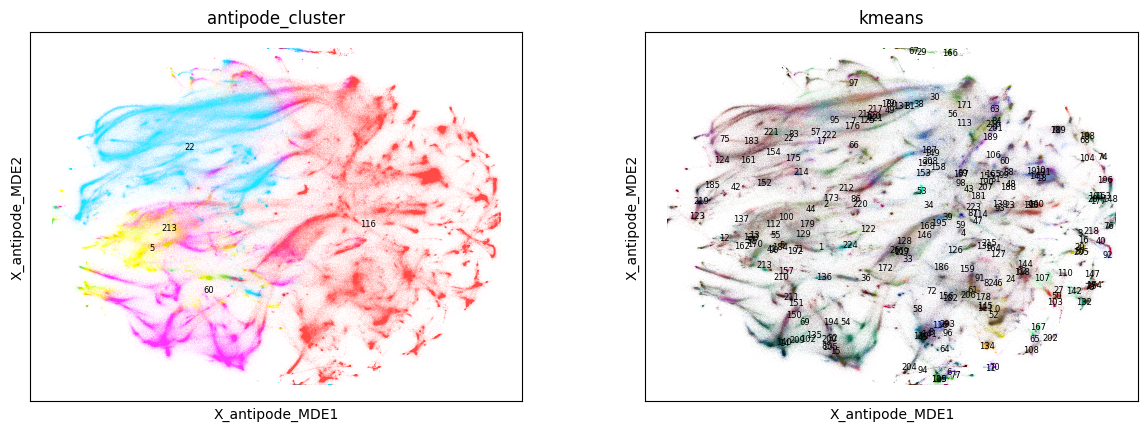

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


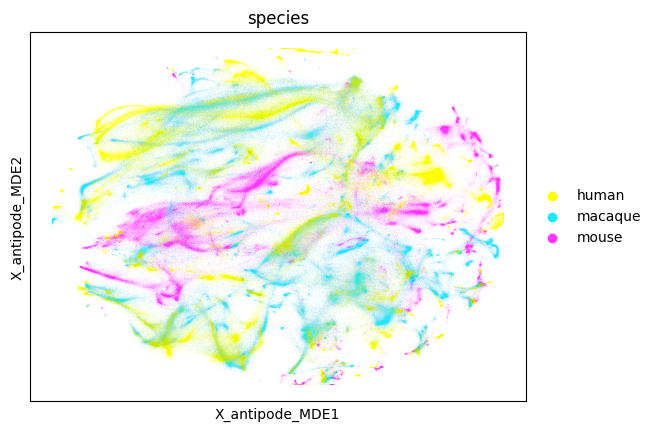

In [37]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode']),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


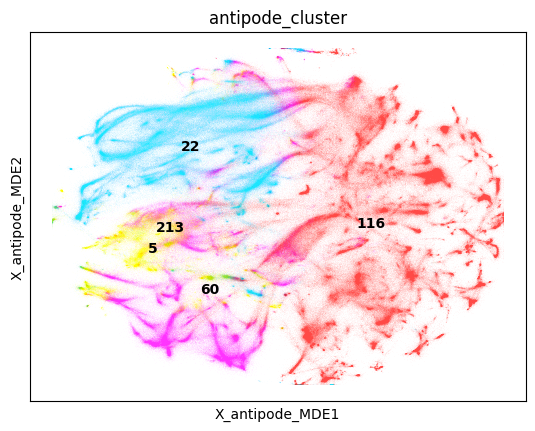

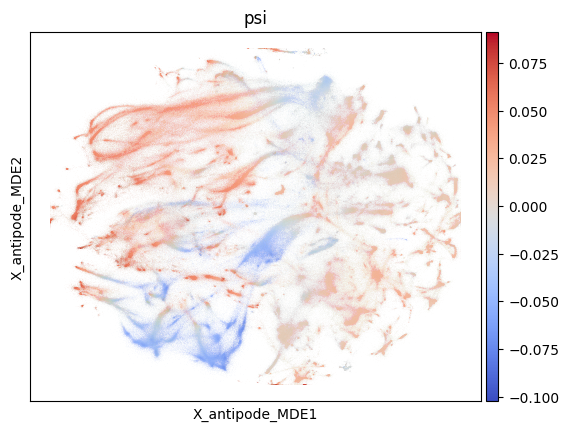

In [38]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["psi"],
    cmap='coolwarm'
)


In [ ]:
#sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster','kmeans'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

random_choice=np.random.choice(adata.obs.index,size=100000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
"""
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)

sc.pl.umap(xdata,color=['species'],use_raw=False,palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,cmap='coolwarm')
sc.pl.umap(xdata,color=['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
"""
# xdata.X=xdata.layers['UMIs'].todense()
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=gene_list,cmap='Purples',use_raw=False)


In [ ]:
xdata.X=xdata.raw.X.todense()[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
#sc.pp.scale(xdata,max_value=10)

gene_list=['RBFOX3','PDGFRA','AQP4','FOXJ1','AIF1','MOG','COL1A2','CD34','COL4A1','SATB2','RORB','DLX2','PROX1','SCGN','TSHZ1','SLC17A7','TLE4','FEZF2',
           'MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','NPY','FOXP1','FOXP2','PDYN','PENK','ISL1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67','RPL7','RPS17','RPL13A','MEF2C']
gene_list=[x for x in gene_list if x in xdata.var.index]
sc.pl.embedding(
    xdata,
    basis=MDE_KEY,
    color=gene_list,cmap='Purples',
    palette=sc.pl.palettes.godsnot_102,legend_fontsize=6,
    legend_loc='on data',use_raw=False
)


In [ ]:
xdata.X=xdata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]

In [ ]:
#xdata.write_h5ad('/home/matthew.schmitz/Matthew/1.9.4_devbigger.h5ad')

In [ ]:
#xdata=sc.read_h5ad('/home/matthew.schmitz/Matthew/1.9.4_devbigger.h5ad')